# 2D Convolution
<font color="red">DRAFT!</font>
Let $a$ and $b$ be 2d arrays with four entries, the convolution of $a$ and $b$ is then a 2d array $c$ with nine entries computed as visualized below: 

<img src="images/conv_2d/gif.gif" />

Formally, the ($i,j$)'th entry of a convolution is given 

$$\gamma_{ij} = \sum_{i,j: i+j=l} \alpha_i \beta_j$$

If we compute all $\gamma_{ij}$ by using the above formula we spend a total of $O(n^4)$ time. It turns out that the 2d DFT allows us to compute 2d convolutions in exactly the same way the <a href="">1d DFT allows us to compute 1d convolution</a>: 

$$\gamma = \text{DFT}_{2d}^{-1} (\text{DFT}_{2d}(x) \odot \text{DFT}_{2d}(y))$$

Here $\odot$ denotes entrywise multiplication. The 2d DFT can be computed in $O(n^2\log n)$ time by using the <a href="https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-046j-design-and-analysis-of-algorithms-spring-2015/lecture-notes/MIT6_046JS15_lec03.pdf">1d algorithm</a> $n$ times. The above formula thus yields a way to compute 2d convolutions in $O(n^2\log n)$ time! 

The following argument shows how we can compute convolutions using the fourier transform using the notation of the <a href="">previous notebook</a> which explains the 1d case. Let $\hat{A},\hat{B}\in\mathbb{R}^{d\times d}$ and $A,B\in\mathbb{R}^{2d\times 2d}$ be the zero padded variants, the 2d fourier transform is then given $FAF$ and $FBF$ respectively. 

$$
\begin{align}
(FAF \odot FBF)_{ij} &= \left(\sum_{l,k} \omega^{il} \alpha_{lk} \omega^{kj} \right) \left(\sum_{p,q} \omega^{ip}\beta_{pq} \omega^{qj}\right) \\ 
&= \sum_{l,k,p,q} \omega^{il} \alpha_{lk} \omega^{kj} \omega^{ip}\beta_{pq} \omega^{qj} \\
&= \sum_{l,k,p,q} \omega^{i(l+p)} \alpha_{lk}\beta_{pq}  \omega^{(k+q)j}\\
&= \sum_{l,p} \omega^{i(l+p)} \sum_{k,q} \alpha_{lk}\beta_{pq}  \omega^{(k+q)j}\\
&= \sum_{l,p} \omega^{i(l+p)} \sum_{\alpha=0,...,n-1}\sum_{k,q: k+q=\alpha} \alpha_{lk}\beta_{pq}  \omega^{\alpha j}\\
&= \sum_{l,p} \omega^{i(l+p)} \sum_{\alpha=0,...,n-1}\omega^{\alpha j}\sum_{k,q: k+q=\alpha} \alpha_{lk}\beta_{pq} 
\end{align}
$$

We thus define $C_{i,j,\alpha}:=\sum_{k,q: k+q=\alpha} \alpha_{lk}\beta_{pq}$ and apply repeat the above trick with respect to $\omega^{i(l+p)}$: 

$$
\begin{align}
\sum_{l,p} \omega^{i(l+p)} \sum_{\alpha=0,...,n-1}\omega^{\alpha j}C_{k,q,\alpha}&=
\sum_{\alpha=0,...,n-1}\omega^{\alpha j} \sum_{l,p} \omega^{i(l+p)} C_{k,q,\alpha} \\
&=\sum_{\alpha=0,...,n-1}\omega^{\alpha j} \sum_{\beta=0,...,n-1}\sum_{l,p: l+p=\beta} \omega^{i(\beta)} C_{k,q,\alpha} \\
&=\sum_{\alpha=0,...,n-1}\omega^{\alpha j} \sum_{\beta=0,...,n-1}\omega^{i(\beta)}\sum_{l,p: l+p=\beta}  C_{k,q,\alpha} 
\end{align}
$$

We then finally define 

$$\gamma_{\alpha,\beta}:=\sum_{l,p: l+p=\beta}  C_{k,q,\alpha}= \sum_{k,q:k+q=\alpha} \sum_{l,p: l+p=\beta} \alpha_{lk}\beta_{pq}$$

Putting all back together we get that: 

$$(FAF \odot FBF)_{ij} = \sum_{\alpha=0,...,n-1}\sum_{\beta=0,...,n-1}\omega^{\alpha j} \omega^{i(\beta)}\gamma_{\alpha\beta}$$

Since $F$ has an inverse it holds that $F^{-1}F\gamma FF^{-1}=\gamma$. In conclusion we get

$$\gamma = \text{DFT}_{2d}^{-1} (\text{DFT}_{2d}(x) \odot \text{DFT}_{2d}(y))$$

The only property we used of $F$ above is (1) it has an inverse and (2) that $F_{ij}=x^{ij}$ for a some special $x$. Since we didn't use any particular property of $\omega$ the above also works for any $x\in \mathbb{C}$ so that (1) is still satisfied. That said, the choice of $\omega$ is important for performing the transform fast.

The code below computes 2d convolution naively and with the DFT. Some might think the DFT variant is simpler to implement as the magic happens in just one line of code when we use a library for DFT. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import dft
from numpy.fft import fft2, ifft2

a = np.array([[1,2],[3,4]])
b = np.array([[5,4],[3,2]])

def convolution_naive(a, b): 
    assert a.shape == b.shape
    
    a = np.concatenate(
            (
            np.concatenate((a,                 np.zeros(a.shape)), axis=1),
            np.concatenate((np.zeros(a.shape), np.zeros(a.shape)), axis=1)
            ), axis=0
    )
                
    b = np.concatenate(
            (
            np.concatenate((np.flip(b),                 np.zeros(b.shape)), axis=1),
            np.concatenate((np.zeros(b.shape), np.zeros(b.shape)), axis=1)
            ), axis=0
    )
    
    n = a.shape[0]
    c = np.zeros(a.shape)
    
    for l in range(c.shape[0]):
        for k in range(c.shape[1]): 
            for i in range(l+1):
                for j in range(k+1):
                    c[l, k] += a[i, j] * b[l-i, k-j]
        
    return c[:n-1, :n-1]

def convolution_dft(a, b): 
    assert a.shape == b.shape
    
    a = np.concatenate(
            (
            np.concatenate((a,                 np.zeros(a.shape)), axis=1),
            np.concatenate((np.zeros(a.shape), np.zeros(a.shape)), axis=1)
            ), axis=0
    )
                
    b = np.concatenate(
            (
            np.concatenate((np.flip(b),                 np.zeros(b.shape)), axis=1),
            np.concatenate((np.zeros(b.shape), np.zeros(b.shape)), axis=1)
            ), axis=0
    )
    
    n = a.shape[0]
    
    conv = ifft2(fft2(a) * fft2(b))
    
    return np.real(conv)[:n-1, :n-1] # numerical errors cause an imaginary part. 

print(a)
print(b)
print(convolution_dft(  a,b))
print(convolution_naive(a,b))


[[1 2]
 [3 4]]
[[5 4]
 [3 2]]
[[ 2.  7.  6.]
 [10. 30. 22.]
 [12. 31. 20.]]
[[ 2.  7.  6.]
 [10. 30. 22.]
 [12. 31. 20.]]


The code below was used to produce the GIF in the start of this post: 

<IPython.core.display.Javascript object>


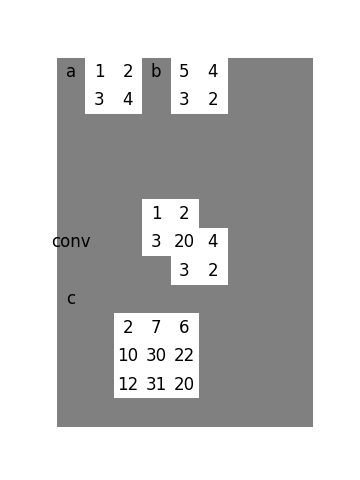

In [39]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

def plot(x, y):
    ax.cla()
    image = np.zeros((13, 2*n-1+6))
    image[0:2, 1:3] = a
    image[0:2, 4:6] = b
    
    image[5:7, 3:5] = a
    image[4+x:6+x, 2+y:4+y] *= b # multiply overlap (they are zero if no overlap)
    indices = (image[4+x:6+x, 2+y:4+y] == 0) # find the zeros that might be left and set those. 
    image[4+x:6+x, 2+y:4+y][indices] = b[indices]
    
    # visualizes the product wrong. 
    for i in range(x+1):
        
        for j in range(y+1):
            image[9+i, 2+j] = conv[i, j]
    
    ax.imshow(image, cmap="gray", vmin=-1, vmax=1)
    
    grid  = np.ndenumerate(image)
    ax.axis('off')
    for (j,i), label in grid: # define grid
        if label != 0.0: ax.text(i,j,int(label),ha='center',va='center')
        
        if i == 0: 
            if j == 0:  ax.text(i,j,"a",ha='center',va='center')
            if j == 6:  ax.text(i,j,"conv",ha='center',va='center')
            if j == 8:  ax.text(i,j,"c",ha='center',va='center')
                    
        if i == 3: 
            if j == 0: ax.text(i,j,"b",ha='center',va='center')
                
                
    #plt.tight_layout()
    plt.pause(.1)
    fig.canvas.draw()
    plt.savefig("images/conv_2d/%i.jpg"%(x*(2*n-1) + y))
    
    #pass # animate a frame, fixate a and move b. 

a = np.array([[1,2],[3,4]])
b = np.array([[5,4],[3,2]])
conv = convolution_dft(a,b)

n = a.shape[0]

fig, ax = plt.subplots(figsize=(3, 4))

for i in range(2*n-1): 
    for j in range(2*n-1):
        plot(i, j)